# NLP Modeling (text classification)

What is it?
- the process of categorizing text into organized groups

Why do we care? 
- allows us to use machine learning to label text

### Vocabulary

**Bag of Words (BoW)**: extracting features from text for use in modeling
- A bag-of-words is a representation of text that describes the occurrence of words within a document. It involves two things:
    - A vocabulary of known words.
    - A measure of the presence of known words.
- It is called a “bag” of words, because any information about the order or structure of words in the document is discarded. The model is only concerned with whether known words occur in the document, not where in the document.


**Term Frequency (TF)**: how often a word appears

- **Raw Count**: This is simply the count of the number of occurances of each word.

- **Frequency**: The number of times each word appears divided by the total number of words.

- **Augmented Frequency**: The frequency of each word divided by the maximum frequency. This can help prevent bias towards larger documents.


**Sparse Matrix**: A matrix in which the number of zero elements is much higher than the number of non-zero elements. As a rule of thumb, if 2/3 of the total elements in a matrix are zeros, it can be called a sparse matrix.

**Feature Extraction (TF-IDF)**

- **TF**: Term Frequency; how often a word appears in a document.

- **IDF**: Inverse Document Frequency; a measure based on in how many documents will a word appear.

- **TF-IDF**: A combination of the two measures above.


## Setup

In [1]:
#wrangle the data
import pandas as pd
import numpy as np

#see the data
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#play with words
import nltk
import re
from pprint import pprint

#split and model
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

#sql creds
import env

In [2]:
def clean(text: str) -> list: # expects the input to be a string and the output to be a list. 
    """A simple function to cleanup text data"""
    
    #remove non-ascii characters & lower
    text = (text.encode('ascii', 'ignore')
                .decode('utf-8', 'ignore')
                .lower())
    
    #remove special characters
    words = re.sub(r'[^\w\s]', '', text).split()
    
    #build the lemmatizer
    wnl = nltk.stem.WordNetLemmatizer()
    
    #getting all stopwords
    stopwords = set(nltk.corpus.stopwords.words('english'))
    
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

## Data Representation

Simple data for demonstration.

In [3]:
corpus = [
    'Python is pretty cool',
    'Python is a nice programming language with nice syntax',
    'I think SQL is cool too',
]

In [4]:
#print it pretty
corpus

['Python is pretty cool',
 'Python is a nice programming language with nice syntax',
 'I think SQL is cool too']

### Term Frequency

Get a count of all the words in the corpus. Then get counts of how many times each word appears in a document.

Use `sklearn.feature_extraction.text.CountVectorizer`

1. make the thing!
2. fit the thing!
3. use the thing!

Attributes of note
- `.todense`
- `.get_feature_names_out`

In [6]:
#import 
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
# make the thing
cv = CountVectorizer()

# fit the thing
# use the thing
bag_of_words = cv.fit_transform(corpus)

In [8]:
bag_of_words

<3x12 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>

In [9]:
#todense
bag_of_words.todense()

matrix([[1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 2, 0, 1, 1, 0, 1, 0, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0]])

Here `bag_of_words` is a **sparse matrix**. Usually you should keep it as such,
but for demonstration we'll view the data within.

In [11]:
# Example
cv.get_feature_names_out()

array(['cool', 'is', 'language', 'nice', 'pretty', 'programming',
       'python', 'sql', 'syntax', 'think', 'too', 'with'], dtype=object)

In [12]:
corpus

['Python is pretty cool',
 'Python is a nice programming language with nice syntax',
 'I think SQL is cool too']

In [15]:
# Taking a look at the bag of words transformation for education and diagnostics.
# In practice this is not necesssary and the resulting data might be to big to be reasonably helpful.
bow = pd.DataFrame(bag_of_words.todense(), columns=cv.get_feature_names_out())

In [14]:
corpus

['Python is pretty cool',
 'Python is a nice programming language with nice syntax',
 'I think SQL is cool too']

In [16]:
# Raw Counts
bow

,cool,is,language,nice,pretty,programming,python,sql,syntax,think,too,with
0,1,1,0,0,1,0,1,0,0,0,0,0
1,0,1,1,2,0,1,1,0,1,0,0,1
2,1,1,0,0,0,0,0,1,0,1,1,0


In [18]:
# Frequency
bow.apply(lambda row: row/row.sum(), axis=1)

,cool,is,language,nice,pretty,programming,python,sql,syntax,think,too,with
0,0.25,0.250,0.000,0.00,0.25,0.000,0.250,0.0,0.000,0.0,0.0,0.000
1,0.00,0.125,0.125,0.25,0.00,0.125,0.125,0.0,0.125,0.0,0.0,0.125
2,0.20,0.200,0.000,0.00,0.00,0.000,0.000,0.2,0.000,0.2,0.2,0.000


In [19]:
# Augmented Frequency
bow.apply(lambda row: (row/row.sum()) / row.max(), axis=1)

,cool,is,language,nice,pretty,programming,python,sql,syntax,think,too,with
0,0.25,0.2500,0.0000,0.000,0.25,0.0000,0.2500,0.0,0.0000,0.0,0.0,0.0000
1,0.00,0.0625,0.0625,0.125,0.00,0.0625,0.0625,0.0,0.0625,0.0,0.0,0.0625
2,0.20,0.2000,0.0000,0.000,0.00,0.0000,0.0000,0.2,0.0000,0.2,0.2,0.0000


In [20]:
# correct formula
# Augmented Frequency
bow.apply(lambda row: .5 + .5 * (row/ row.max()), axis=1)

,cool,is,language,nice,pretty,programming,python,sql,syntax,think,too,with
0,1.0,1.00,0.50,0.5,1.0,0.50,1.00,0.5,0.50,0.5,0.5,0.50
1,0.5,0.75,0.75,1.0,0.5,0.75,0.75,0.5,0.75,0.5,0.5,0.75
2,1.0,1.00,0.50,0.5,0.5,0.50,0.50,1.0,0.50,1.0,1.0,0.50


### TF-IDF (term frequency - inverse document frequency)

- a measure that helps identify how important a word is in a document
- tf is for a single document, idf is for a corpus
- combination of how often a word appears in a document (**tf**) and how unique the word
  is among documents (**idf**)

#### IDF

For example, imagine we have 20 documents. We can visualize what the idf score looks like with the code below:

Text(0.5, 1.0, 'IDF for a given word')

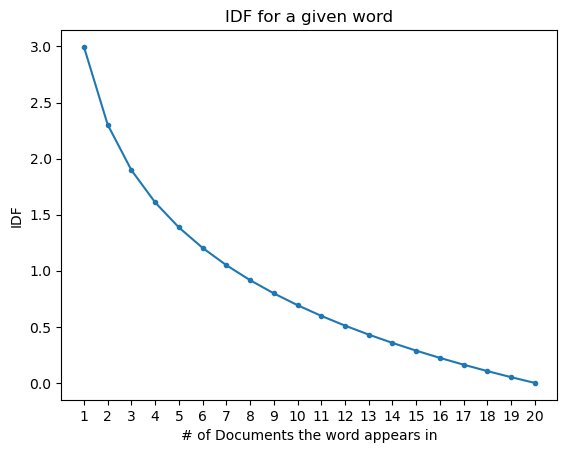

In [21]:
n_documents = 20

x = np.arange(1, n_documents + 1)
y = np.log(n_documents / x)

plt.plot(x, y, marker='.')

plt.xticks(x)
plt.xlabel('# of Documents the word appears in')
plt.ylabel('IDF')
plt.title('IDF for a given word')

#### TF-IDF

Use `sklearn.feature_extraction.text.TfidfVectorizer`
1. make the thing! 
2. fit the thing!
3. use the thing! 

In [24]:
#import
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
#make it
tfidf = TfidfVectorizer()

#fit it/use it
bag_of_words = tfidf.fit_transform(corpus)

In [26]:
bag_of_words.todense()

matrix([[0.4804584 , 0.37311881, 0.        , 0.        , 0.63174505,
         0.        , 0.4804584 , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.19767284, 0.33468921, 0.66937843, 0.        ,
         0.33468921, 0.25453977, 0.        , 0.33468921, 0.        ,
         0.        , 0.33468921],
        [0.38376993, 0.29803159, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.50461134, 0.        , 0.50461134,
         0.50461134, 0.        ]])

In [27]:
#dataframe it
pd.DataFrame(bag_of_words.todense(), columns=tfidf.get_feature_names_out())

,cool,is,language,nice,pretty,programming,python,sql,syntax,think,too,with
0,0.480458,0.373119,0.000000,0.000000,0.631745,0.000000,0.480458,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.197673,0.334689,0.669378,0.000000,0.334689,0.254540,0.000000,0.334689,0.000000,0.000000,0.334689
2,0.383770,0.298032,0.000000,0.000000,0.000000,0.000000,0.000000,0.504611,0.000000,0.504611,0.504611,0.000000


In [28]:
corpus

['Python is pretty cool',
 'Python is a nice programming language with nice syntax',
 'I think SQL is cool too']

In [32]:
tfidf.idf_

array([1.28768207, 1.        , 1.69314718, 1.69314718, 1.69314718,
       1.69314718, 1.28768207, 1.69314718, 1.69314718, 1.69314718,
       1.69314718, 1.69314718])

To get the idf score for each word (these aren't terribly useful themselves):

In [31]:
# zip: put these two things of the same length together
# dict: turn those two associated things into a k: v pair
# pd.Series: turn those keys into indices, and the values into values
pd.Series(dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))).sort_values()

is             1.000000
cool           1.287682
python         1.287682
language       1.693147
nice           1.693147
pretty         1.693147
programming    1.693147
sql            1.693147
syntax         1.693147
think          1.693147
too            1.693147
with           1.693147
dtype: float64

### Bag Of Ngrams

For either `CountVectorizer` or `TfidfVectorizer`, you can set the `ngram_range`
parameter.

In [33]:
corpus

['Python is pretty cool',
 'Python is a nice programming language with nice syntax',
 'I think SQL is cool too']

In [34]:
#get two words at once!
cv = CountVectorizer(ngram_range=(2,2))
bag_of_grams = cv.fit_transform(corpus)

In [35]:
#dataframe it
pd.DataFrame(bag_of_grams.todense(), columns=cv.get_feature_names_out())

,cool too,is cool,is nice,is pretty,language with,nice programming,nice syntax,pretty cool,programming language,python is,sql is,think sql,with nice
0,0,0,0,1,0,0,0,1,0,1,0,0,0
1,0,0,1,0,1,1,1,0,1,1,0,0,1
2,1,1,0,0,0,0,0,0,0,0,1,1,0


In [36]:
#make it
corpus

['Python is pretty cool',
 'Python is a nice programming language with nice syntax',
 'I think SQL is cool too']

## Modeling

Use the ham spam data to walk through the pipeline! 

#### Aquire

In [37]:
url = env.get_db_url('spam_db')
query = "select * from spam"

df = pd.read_sql(query, url, index_col='id')
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### Prepare

In [38]:
df['clean_text'] = df.text.apply(clean).apply(' '.join)

In [39]:
df.head()

,label,text,clean_text
id,,,
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though


#### Explore

In [40]:
train, test = train_test_split(df, test_size=0.2, stratify=df.label, random_state=1234)

In [41]:
print(train.shape)
print(test.shape)

(4457, 3)
(1115, 3)


In [42]:
train.head()

,label,text,clean_text
id,,,
1001,spam,Please call our customer service representativ...,please call customer service representative fr...
2889,ham,Shuhui has bought ron's present it's a swatch ...,shuhui bought ron present swatch watch
833,ham,Thank you so much. When we skyped wit kz and s...,thank much skyped wit kz sura didnt get pleasu...
1241,ham,"I want to show you the world, princess :) how ...",want show world princess europe
4124,ham,May b approve panalam...but it should have mor...,may b approve panalambut post


In [43]:
' '.join(train.clean_text)[:100]

'please call customer service representative freephone 0808 145 4742 9am11pm guaranteed 1000 cash 500'

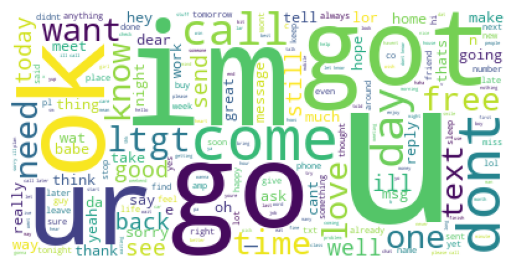

In [44]:
img = WordCloud(background_color='white').generate(' '.join(train.clean_text))
plt.imshow(img)
plt.axis('off')
plt.show()

Is this useful? idk. If it's not, don't share it. 

#### Model

In [45]:
X_train = train.clean_text
y_train = train.label

In [46]:
X_test = test.clean_text
y_test = test.label

In [47]:
X_train.head()

id
1001    please call customer service representative fr...
2889               shuhui bought ron present swatch watch
833     thank much skyped wit kz sura didnt get pleasu...
1241                      want show world princess europe
4124                        may b approve panalambut post
Name: clean_text, dtype: object

In [48]:
y_train.head()

id
1001    spam
2889     ham
833      ham
1241     ham
4124     ham
Name: label, dtype: object

#### Reminder: Whatever transformations we apply to X_train need to be applied to X_test

In [54]:
#make my bag of words
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train)
X_test_bow = cv.transform(X_test)

In [56]:
#build my model
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_bow, y_train)
tree.score(X_bow, y_train)

0.923939869867624

In [57]:
#evaluate on test
tree.score(X_test_bow, y_test)

0.9139013452914798

### Modeling Results

A super-useful feature of decision trees and linear models is that they do some
built-in feature selection through the coefficeints or feature importances:

In [58]:
pd.Series(
    dict(
        zip(cv.get_feature_names_out(), 
            tree.feature_importances_))).sort_values().tail()

im      0.041586
ill     0.071070
free    0.096604
txt     0.341116
call    0.441919
dtype: float64

## Next Steps

- Try other model types
    - [Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)
    ([`sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html))
    is a very popular classifier for NLP tasks.

- Look at other metrics, is accuracy the best choice here?

- Try ngrams instead of single words

- Try a combination of ngrams and words (`ngram_range=(1, 2)` for words and
  bigrams)

- Try using tf-idf instead of bag of words

- Combine the top `n` performing words with the other features that you have
  engineered (the `CountVectorizer` and `TfidfVectorizer` have a `vocabulary`
  argument you can use to restrict the words used)